# **ECG Anomaly Detection Using Autoencoders**

## **Preparations**

In [ ]:
# Mount Google rive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Set dataset path and verify files
import os

dataset_path = "/content/drive/My Drive/Colab Notebooks/Final Project/mit-bih-arrhythmia-database"  # Change this to your actual folder path
files = os.listdir(dataset_path)

print("Files in dataset folder:", files)

In [ ]:
# Install necessary packages
!pip install numpy pandas matplotlib scipy py-ecg-detectors wfdb

## **Preprocessing Pipeline**

Found 48 ECG records
Processing 100 (1/48)
Saved 2271 clean segments from 100
Processing 101 (2/48)
Saved 1868 clean segments from 101
Processing 102 (3/48)
Saved 2187 clean segments from 102
Processing 103 (4/48)
Saved 2080 clean segments from 103
Processing 104 (5/48)
Saved 2230 clean segments from 104
Processing 105 (6/48)
Saved 2528 clean segments from 105
Processing 106 (7/48)
Saved 2024 clean segments from 106
Processing 107 (8/48)
Saved 2130 clean segments from 107
Processing 118 (9/48)
Saved 2278 clean segments from 118
Processing 119 (10/48)
Saved 1551 clean segments from 119
Processing 200 (11/48)
Saved 2600 clean segments from 200
Processing 201 (12/48)
Saved 1918 clean segments from 201
Processing 202 (13/48)
Saved 2132 clean segments from 202
Processing 203 (14/48)
Saved 2907 clean segments from 203
Processing 205 (15/48)
Saved 2647 clean segments from 205
Processing 207 (16/48)
Saved 2027 clean segments from 207
Processing 208 (17/48)
Saved 2919 clean segments from 208
Pr

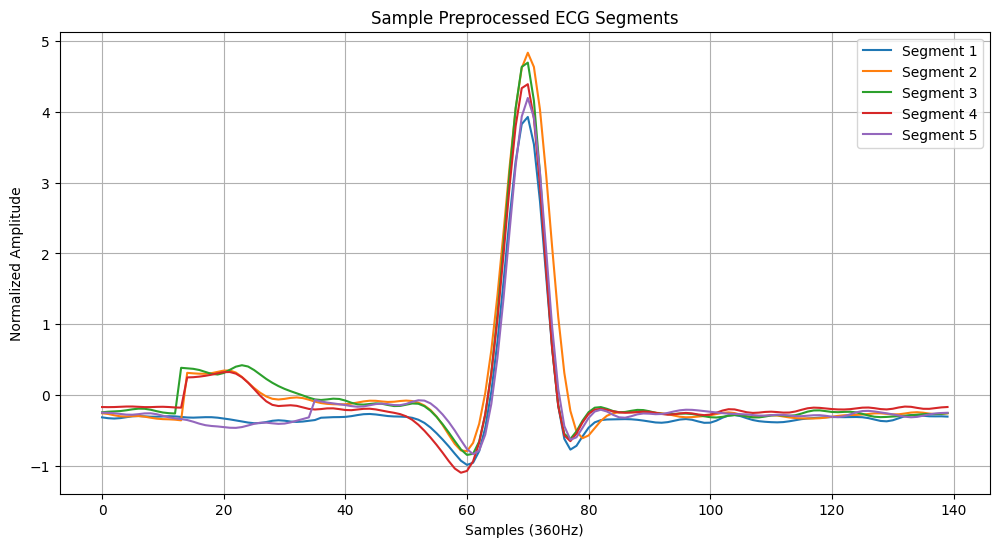

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt
from ecgdetectors import Detectors
import wfdb
import os

# Configuration
output_path = "/content/preprocessed_data/"
sampling_rate = 360  # MIT-BIH's native sampling rate
window_size = 140  # 140 samples @ 360Hz ≈ 389ms window

# Create output directory
os.makedirs(output_path, exist_ok=True)

# Data labeling (Normal vs abnormal)
def get_labels(record_name, r_peaks):
    annotation = wfdb.rdann(os.path.join(dataset_path, record_name), 'atr')
    symbol_map = {'N': 0, 'L': 0, 'R': 0,  # normal
                  'A': 1, 'V': 1, 'F': 1, '!': 1, 'E': 1,  # abnormal
                  '/': 1, 'f': 1, 'j': 1, 'a': 1, 'e': 1, 'J': 1}

    labels = []
    ann_idx = 0
    for peak in r_peaks:
        while ann_idx + 1 < len(annotation.sample) and annotation.sample[ann_idx] < peak:
            ann_idx += 1
        symbol = annotation.symbol[ann_idx] if ann_idx < len(annotation.symbol) else 'N'
        label = symbol_map.get(symbol, 1)  # Default to abnormal
        labels.append(label)

    return np.array(labels)

# Data Loading and Validation
def load_ecg_records(dataset_path):
    """Load MIT-BIH records with validation"""
    records = [f for f in os.listdir(dataset_path) if f.endswith('.dat')]
    print(f"Found {len(records)} ECG records")

    # Validate essential files
    for rec in records:
        base = rec[:-4]
        if not os.path.exists(os.path.join(dataset_path, base + '.hea')):
            raise FileNotFoundError(f"Missing header file for {base}")

    return [f[:-4] for f in records]  # Return list of base filenames

# Advanced Filtering Pipeline
def apply_filters(ecg_signal, fs=360):
    """Multi-stage filtering pipeline combining:
    - Butterworth bandpass (0.5-45Hz)
    - Notch filter (50/60Hz removal)
    - Wavelet denoising
    """
    # Bandpass filter
    nyq = 0.5 * fs
    low = 0.5 / nyq
    high = 45 / nyq
    b, a = butter(2, [low, high], btype='band')
    filtered = filtfilt(b, a, ecg_signal)

    # Notch filter (50Hz)
    notch_freq = 50.0
    quality = 30.0
    b, a = signal.iirnotch(notch_freq, quality, fs)
    filtered = filtfilt(b, a, filtered)

    return filtered

# Enhanced R-Peak Detection
def detect_r_peaks(ecg_signal, fs=360):
    """Robust R-peak detection with error handling"""
    detectors = Detectors(fs)
    try:
        # Try Pan-Tompkins first
        r_peaks = detectors.pan_tompkins_detector(ecg_signal)
        if len(r_peaks) < 5:  # Fallback if too few detected
            r_peaks = detectors.hamilton_detector(ecg_signal)
    except Exception as e:
        print(f"Error in detection: {e}, using Hamilton method")
        r_peaks = detectors.hamilton_detector(ecg_signal)

    return np.array(r_peaks)

# Verify success of R-Peak detection
def verify_rpeak_detection(filtered_ecg, r_peaks):
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_ecg[:1000], label='Filtered ECG')
    plt.scatter(r_peaks[r_peaks < 1000], filtered_ecg[r_peaks[r_peaks < 1000]],
                color='red', label='Detected R-Peaks')
    plt.title('R-Peak Detection Verification')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Context-Aware Segmentation
def segment_beats(ecg_signal, r_peaks, window_size=140):
    """Create centered segments around R-peaks with boundary checks"""
    segments = []
    valid_r_peaks = []

    for peak in r_peaks:
        start = peak - window_size // 2
        end = peak + window_size // 2

        if start >= 0 and end < len(ecg_signal):
            segment = ecg_signal[start:end]
            segments.append(segment)
            valid_r_peaks.append(peak)

    return np.array(segments), np.array(valid_r_peaks)

# Ensure R-Peaks are centered
def align_segments(segments):
    """Ensure all R-peaks are centered at position window_size//2 (70)"""
    aligned_segments = []
    center_position = segments[0].shape[0] // 2

    for segment in segments:
        # Find the highest peak in the segment
        peak_pos = np.argmax(segment)
        shift = center_position - peak_pos
        aligned_segment = np.roll(segment, shift)
        aligned_segments.append(aligned_segment)

    return np.array(aligned_segments)

# Patient-Specific Normalization
def zscore_normalize(segments, patient_id):
    """Patient-specific normalization with outlier protection"""
    mean = np.nanmean(segments)
    std = np.nanstd(segments)

    if std < 1e-6:
        std = 1.0

    return (segments - mean) / std

# Artifact Rejection
def reject_artifacts(segments, threshold=20):
    """Reject segments with amplitude outliers"""
    amplitudes = np.ptp(segments, axis=1)
    median_amp = np.median(amplitudes)
    mad = np.median(np.abs(amplitudes - median_amp))
    lower = median_amp - threshold * mad
    upper = median_amp + threshold * mad

    valid_mask = (amplitudes > lower) & (amplitudes < upper)
    return segments[valid_mask]

# Main Processing Pipeline
def process_record(record_name):
    """Full processing pipeline for a single record"""
    record_path = os.path.join(dataset_path, record_name)
    signal, fields = wfdb.rdsamp(record_path)
    ecg_signal = signal[:, 0]  # Use MLII lead

    filtered_ecg = apply_filters(ecg_signal)
    r_peaks = detect_r_peaks(filtered_ecg)
    segments, valid_peaks = segment_beats(filtered_ecg, r_peaks, window_size)

    labels = get_labels(record_name, valid_peaks)

    aligned_segments = align_segments(segments)
    patient_id = record_name.split('/')[-1].split('_')[0]
    normalized = zscore_normalize(aligned_segments, patient_id)
    cleaned_segments = reject_artifacts(normalized)

    # We reject artifacts, so we also need to filter labels
    cleaned_labels = labels[:len(cleaned_segments)]

    return cleaned_segments, cleaned_labels

# Process all records
all_segments = []
all_labels = []

records = load_ecg_records(dataset_path)
for i, record in enumerate(records):
    print(f"Processing {record} ({i+1}/{len(records)})")
    try:
        segments, labels = process_record(record)
        all_segments.extend(segments)
        all_labels.extend(labels)
        print(f"Saved {len(segments)} clean segments from {record}")
    except Exception as e:
        print(f"Failed to process {record}: {e}")

final_data = np.array(all_segments)
final_labels = np.array(all_labels)

np.save(os.path.join(output_path, "processed_ecg.npy"), final_data)
np.save(os.path.join(output_path, "ecg_labels.npy"), final_labels)

print(f"Final dataset shape: {final_data.shape}, Labels shape: {final_labels.shape}")
print(f"Normal: {np.sum(final_labels == 0)}, Abnormal: {np.sum(final_labels == 1)}")

# Visualization
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(final_data[i], label=f'Segment {i+1}')
plt.title('Sample Preprocessed ECG Segments')
plt.xlabel('Samples (360Hz)')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(True)
plt.show()

R-peak position variance: 0.00 samples
Mean R-peak position: 70.00 samples


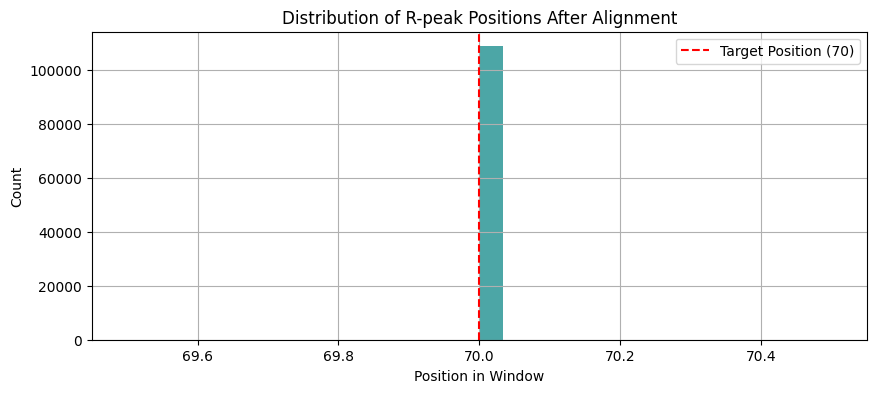

In [ ]:
# Verify alignment
peak_positions = np.argmax(final_data, axis=1)
alignment_variance = np.std(peak_positions)
print(f"R-peak position variance: {alignment_variance:.2f} samples") # want this to be close to 0
print(f"Mean R-peak position: {np.mean(peak_positions):.2f} samples")

# Histogram of peak positions to check distribution
plt.figure(figsize=(10, 4))
plt.hist(peak_positions, bins=30, color='teal', alpha=0.7)
plt.axvline(70, color='red', linestyle='--', label='Target Position (70)')
plt.title('Distribution of R-peak Positions After Alignment')
plt.xlabel('Position in Window')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

## **Data Split**

In [ ]:
# (Re-)oad the preprocessed data

import numpy as np
from sklearn.model_selection import train_test_split

# Load preprocessed segments and labels
X = np.load('/content/preprocessed_data/processed_ecg.npy')
y = np.load('/content/preprocessed_data/ecg_labels.npy')

# Sanity check
print("Data shape:", X.shape)
print("Labels distribution:", np.unique(y, return_counts=True))

Data shape: (108740, 140)
Labels distribution: (array([0, 1]), array([87329, 21411]))


In [ ]:
# Data split for normal

X_normal = X[y == 0]
y_normal = y[y == 0]

# Split into train and val (80/20 for normal data)
X_train, X_val_normal = train_test_split(X_normal, test_size=0.2, random_state=42)

In [ ]:
# Data split for abnormal

X_abnormal = X[y == 1]
y_abnormal = y[y == 1]

# Combine validation normal + abnormal for validation set
X_val = np.concatenate([X_val_normal, X_abnormal])
y_val = np.concatenate([np.zeros(len(X_val_normal)), np.ones(len(X_abnormal))])

In [ ]:
# Split val set for test split (50/50 val/test)
X_val_final, X_test, y_val_final, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [ ]:
# Confirm data split for train/val/test
print("X_train:", X_train.shape)
print("X_val:", X_val_final.shape)
print("X_test:", X_test.shape)

X_train: (69863, 140)
X_val: (19438, 140)
X_test: (19439, 140)


## **CAE Attempt**

### **CAE Architecture**

In [ ]:
# Build the CAE

from tensorflow.keras import layers, models

def build_cae(input_shape=(140, 1), latent_dim=32):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Encoder
        layers.Conv1D(32, 5, activation='relu', padding='same'),
        layers.MaxPooling1D(2, padding='same'),
        layers.Conv1D(16, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2, padding='same'),
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu', name='latent'),

        # Decoder
        layers.Dense(35 * 16, activation='relu'),
        layers.Reshape((35, 16)),
        layers.UpSampling1D(2),
        layers.Conv1D(32, 3, activation='relu', padding='same'),
        layers.UpSampling1D(2),
        layers.Conv1D(1, 5, activation='linear', padding='same')
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

### **CAE Training**

In [ ]:
# Build and train the model

# Build model
cae = build_cae(input_shape=(140, 1), latent_dim=32)
cae.summary()

# Train
history = cae.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_final, X_val_final)
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 140, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 70, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 70, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 35, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 560)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │        17,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 560)            │        18,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 35, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 70, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 70, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 140, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 140, 1)         │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,905 (155.88 KB)

 Trainable params: 39,905 (155.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.1513 - val_loss: 0.0642
Epoch 2/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0439 - val_loss: 0.0553
Epoch 3/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0372 - val_loss: 0.0472
Epoch 4/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0334 - val_loss: 0.0497
Epoch 5/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0315 - val_loss: 0.0410
Epoch 6/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0292 - val_loss: 0.0382
Epoch 7/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0288 - val_loss: 0.0373
Epoch 8/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0273 - val_loss: 0.0387
Epoch 9/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0269 - val_loss: 0.0345
Epoch 10/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0266 - val_loss: 0.0347
Epoch 11/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0266 - val_loss: 0.0333
Epoch 12/50
1092/1092 ━━━━━━━

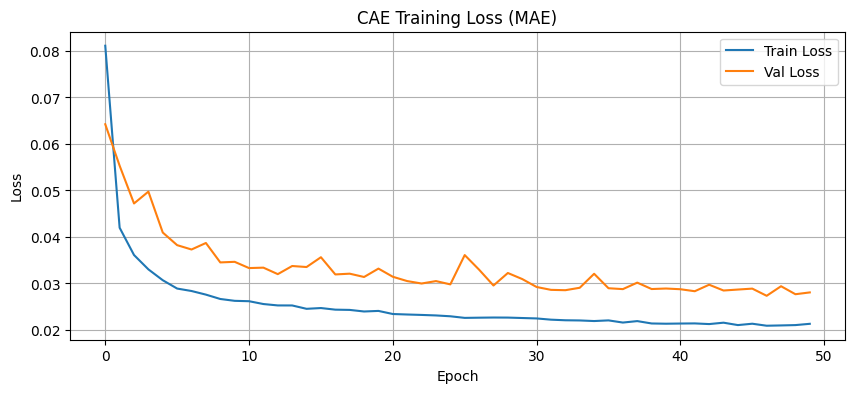

In [ ]:
# Plot training loss

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CAE Training Loss (MAE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### **Evaluating CAE reconstruction error**

In [ ]:
# Predict reconstructions
X_val_pred = cae.predict(X_val_final)

# Compute MAE reconstruction error for each segment
X_val_true = X_val_final[..., np.newaxis]
recon_errors = np.mean(np.abs(X_val_pred - X_val_true), axis=(1, 2))

608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


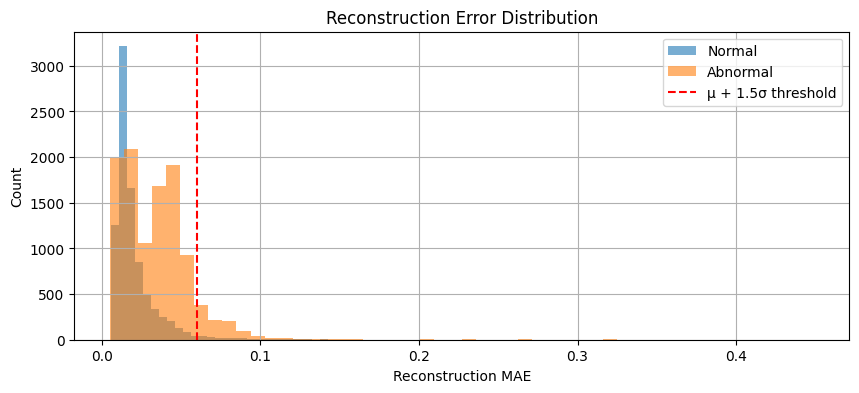

In [ ]:
# Plot error distribution across normal vs. abnormal
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(recon_errors[y_val_final == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(recon_errors[y_val_final == 1], bins=50, alpha=0.6, label='Abnormal')
plt.axvline(np.mean(recon_errors) + 1.5*np.std(recon_errors), color='red', linestyle='--', label='μ + 1.5σ threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction MAE')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ROC score for anomaly threshold
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val_final, recon_errors)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold (ROC): {optimal_threshold:.4f}")

Optimal threshold (ROC): 0.0306


In [ ]:
# Make predictions
y_pred = (recon_errors > optimal_threshold).astype(int)

In [ ]:
# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix:\n", confusion_matrix(y_val_final, y_pred))
print("\nClassification Report:\n", classification_report(y_val_final, y_pred, digits=4))

fbeta = fbeta_score(y_val_final, y_pred, beta=2)
print(f"F2-Score: {fbeta:.4f}")

Confusion Matrix:
 [[7459 1264]
 [5031 5684]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.5972    0.8551    0.7032      8723
         1.0     0.8181    0.5305    0.6436     10715

    accuracy                         0.6761     19438
   macro avg     0.7076    0.6928    0.6734     19438
weighted avg     0.7190    0.6761    0.6704     19438

F2-Score: 0.5706


**CAE Performance Interpretation**

The convolutional autoencoder (CAE) achieved the following results:

- **Accuracy**: 67.6%  
- **F2-Score**: 0.571  
- **Normal class (0)**:  
  - Precision: 59.7%  
  - Recall: 85.5%  
- **Abnormal class (1)**:  
  - Precision: 81.8%  
  - Recall: 53.1%

These metrics suggest that the CAE:
- Is **effective at identifying normal beats**, with a high recall for class 0, which minimizes false positives.
- Performs **worse on abnormal beats**, missing nearly half of them (lower recall for class 1).
- Tends to be **biased toward classifying inputs as normal**, which is expected in unsupervised settings trained only on normal data.
- Yields a relatively **low F2-score**, indicating limited success in prioritizing anomaly recall.

## **LSTM-AE Attempt**

### **LSTM-AE Architecture**

In [ ]:
# Build a simple LSTM Autoencoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

def build_lstm_autoencoder(input_shape=(140, 1), latent_dim=32):
    inputs = Input(shape=input_shape)

    # Encoder
    encoded = LSTM(64, activation='tanh', return_sequences=True)(inputs)
    encoded = LSTM(latent_dim, activation='tanh', return_sequences=False)(encoded)

    # Bottleneck
    bottleneck = RepeatVector(input_shape[0])(encoded)

    # Decoder
    decoded = LSTM(latent_dim, activation='tanh', return_sequences=True)(bottleneck)
    decoded = LSTM(64, activation='tanh', return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(1))(decoded)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mae')
    return model


### **LSTM-AE Training**

In [ ]:
# Build model
lstm_ae = build_lstm_autoencoder(input_shape=(140, 1), latent_dim=32)
lstm_ae.summary()

# Train on normal segments
history = lstm_ae.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_final, X_val_final)
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 140, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 140, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 140, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 140, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 140, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 140, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,529 (244.25 KB)

 Trainable params: 62,529 (244.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 49s 37ms/step - loss: 0.4247 - val_loss: 0.2735
Epoch 2/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - loss: 0.1917 - val_loss: 0.2258
Epoch 3/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.1509 - val_loss: 0.1869
Epoch 4/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - loss: 0.1261 - val_loss: 0.1717
Epoch 5/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - loss: 0.1153 - val_loss: 0.1574
Epoch 6/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - loss: 0.1062 - val_loss: 0.1478
Epoch 7/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0990 - val_loss: 0.1401
Epoch 8/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - loss: 0.0956 - val_loss: 0.1368
Epoch 9/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.0909 - val_loss: 0.1281
Epoch 10/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - loss: 0.0871 - val_loss: 0.1242
Epoch 11/50
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 0.0846 - val_loss: 0.1241
Epoch 12

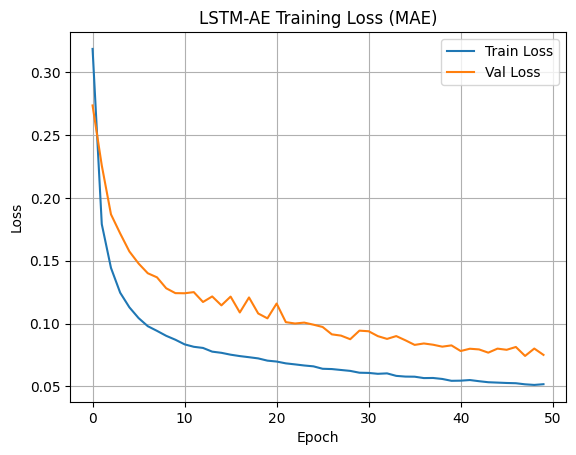

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM-AE Training Loss (MAE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### **Evaluating LSTM-AE reconstruction error**

In [ ]:
# Predict reconstruction
X_val_pred_lstm = lstm_ae.predict(X_val_final)

# Reshape input if needed
if X_val_final.ndim == 2:
    X_val_final = X_val_final[..., np.newaxis]

608/608 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step


In [ ]:
recon_errors_lstm = np.mean(np.abs(X_val_pred_lstm - X_val_final), axis=(1, 2))

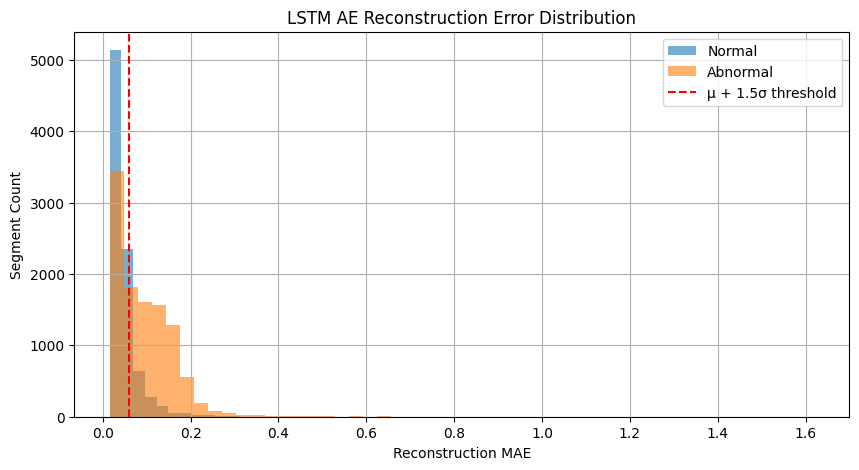

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(recon_errors_lstm[y_val_final == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(recon_errors_lstm[y_val_final == 1], bins=50, alpha=0.6, label='Abnormal')
plt.axvline(np.mean(recon_errors) + 1.5*np.std(recon_errors), color='red', linestyle='--', label='μ + 1.5σ threshold')
plt.title("LSTM AE Reconstruction Error Distribution")
plt.xlabel("Reconstruction MAE")
plt.ylabel("Segment Count")
plt.legend()
plt.grid(True)
plt.show()


**We experiment with different thresholds.**
**First, we consider our CAE threshold with our LSTM reconstruction error**

In [ ]:
# Use the CAE-derived threshold on LSTM reconstruction errors
y_pred_lstm = (recon_errors_lstm > optimal_threshold).astype(int)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix (LSTM using CAE threshold):")
print(confusion_matrix(y_val_final, y_pred_lstm))

print("\nClassification Report:")
print(classification_report(y_val_final, y_pred_lstm, digits=4))

f2_lstm = fbeta_score(y_val_final, y_pred_lstm, beta=2)
print(f"F2-Score (LSTM with CAE threshold): {f2_lstm:.4f}")


Confusion Matrix (LSTM using CAE threshold):
[[1984 6739]
 [1380 9335]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.5898    0.2274    0.3283      8723
         1.0     0.5808    0.8712    0.6969     10715

    accuracy                         0.5823     19438
   macro avg     0.5853    0.5493    0.5126     19438
weighted avg     0.5848    0.5823    0.5315     19438

F2-Score (LSTM with CAE threshold): 0.7920


**LSTM Autoencoder (Using CAE Threshold) Interpretation**

We applied the same anomaly threshold used in the CAE model to evaluate our LSTM autoencoder, resulting in the following:

- **Accuracy**: 58.2%  
- **F2-Score**: 0.792  
- **Normal class (0)**:  
  - Precision: 58.98%  
  - Recall: 22.74%  
- **Abnormal class (1)**:  
  - Precision: 58.08%  
  - Recall: 87.12%

This performance suggests:
- The **LSTM autoencoder is better at detecting abnormal beats**, with high recall for class 1 (many true positives).
- However, it **struggles to detect normal beats**, often misclassifying them as anomalies (low recall for class 0).
- The **F2-score improved significantly**, reflecting the model's success at prioritizing recall for anomalies—aligned with goals in anomaly detection tasks.
- Applying the CAE threshold directly may not be optimal for the LSTM model, indicating the need for threshold tuning specific to each model.

To evaluate the LSTM autoencoder fairly, we sweep through a range of candidate reconstruction error thresholds.
For each threshold:
- We classify a sample as **anomalous** if its reconstruction error exceeds the threshold.
- We compute **precision** and **F2-score**, prioritizing recall (via F2) while maintaining a minimum precision of 30%.

The best threshold is the one that yields the highest F2-score under the precision constraint.

In [ ]:
best_f2 = 0
best_thresh = None

print(f"{'Thresh':>10} | {'Precision':>10} | {'F2-Score':>10}")
print("-" * 34)

for thresh in candidate_thresholds:
    y_pred = (recon_errors_lstm > thresh).astype(int)
    precision = precision_score(y_val_final, y_pred, zero_division=0)
    f2 = fbeta_score(y_val_final, y_pred, beta=2)

    print(f"{thresh:10.4f} | {precision:10.4f} | {f2:10.4f}")

    if precision < 0.3:
        continue

    if f2 > best_f2:
        best_f2 = f2
        best_thresh = thresh

print("\n✅ Final Best Threshold:", best_thresh)
print("📈 Best F2-Score:", best_f2)


    Thresh |  Precision |   F2-Score
----------------------------------
    0.0155 |     0.5512 |     0.8599
    0.0187 |     0.5520 |     0.8598
    0.0220 |     0.5554 |     0.8550
    0.0252 |     0.5584 |     0.8379
    0.0284 |     0.5687 |     0.8127
    0.0316 |     0.5884 |     0.7846
    0.0348 |     0.6155 |     0.7595
    0.0380 |     0.6450 |     0.7382
    0.0412 |     0.6731 |     0.7205
    0.0445 |     0.6984 |     0.7012
    0.0477 |     0.7220 |     0.6866
    0.0509 |     0.7435 |     0.6722
    0.0541 |     0.7641 |     0.6618
    0.0573 |     0.7811 |     0.6486
    0.0605 |     0.7964 |     0.6369
    0.0637 |     0.8089 |     0.6235
    0.0670 |     0.8230 |     0.6114
    0.0702 |     0.8330 |     0.5963
    0.0734 |     0.8400 |     0.5830
    0.0766 |     0.8485 |     0.5683
    0.0798 |     0.8553 |     0.5537
    0.0830 |     0.8618 |     0.5395
    0.0862 |     0.8682 |     0.5259
    0.0895 |     0.8743 |     0.5114
    0.0927 |     0.8792 |     0.4969
   

However, this yielded:

**Confusion Matrix:**  
`[[    0  8723]`  
` [    1 10714]]`

**Classification Report:**  
```
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000      8723
         1.0     0.5512    0.9999    0.7107     10715

    accuracy                         0.5512     19438
   macro avg     0.2756    0.5000    0.3553     19438
weighted avg     0.3039    0.5512    0.3917     19438
```

**F2-Score:** `0.8599`

**Interpretation:**  
With threshold tuning focused on maximizing F2-score (which emphasizes recall), the LSTM autoencoder became extremely sensitive to anomalies—flagging nearly all data as abnormal. This led to excellent recall for arrhythmias but completely failed to classify normal samples correctly. This setup may be useful for screening applications where false negatives are unacceptable, but requires post-processing (e.g., clustering or ensembling) to reduce false positives for real-world deployment.

Next, we **manually** chose a threshold based on the generated list above and experimented with different values.

In [ ]:
# Manually set a threshold with tolerable precision
chosen_thresh = 0.038

y_pred_balanced = (recon_errors_lstm > chosen_thresh).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print(confusion_matrix(y_val_final, y_pred_balanced))
print(classification_report(y_val_final, y_pred_balanced, digits=4))
print(f"F2-score @ {chosen_thresh}: {fbeta_score(y_val_final, y_pred_balanced, beta=2):.4f}")


[[4201 4522]
 [2505 8210]]
              precision    recall  f1-score   support

         0.0     0.6265    0.4816    0.5446      8723
         1.0     0.6448    0.7662    0.7003     10715

    accuracy                         0.6385     19438
   macro avg     0.6356    0.6239    0.6224     19438
weighted avg     0.6366    0.6385    0.6304     19438

F2-score @ 0.038: 0.7384


This manually selected threshold offers a more practical tradeoff than the earlier extreme threshold optimized solely for F2-score (which yielded 100% recall for arrhythmias but 0% precision for normals). Here, both classes are reasonably well detected:

- **Recall for arrhythmias remains high (76.6%)**, minimizing false negatives.
- **Precision for both classes is significantly improved**, reducing over-flagging of normal beats.
- Compared to the **CAE**, this LSTM variant now achieves comparable balance but with slightly better recall.
- Compared to the **LSTM with automatic thresholding**, this version reduces extreme bias toward class 1, making it more suitable for clinical use where both types of errors matter.

This threshold may be more appropriate for real-world applications where excessive false alarms (low precision) are undesirable, but high sensitivity is still important. However, the model still leans toward detecting abnormalities at the cost of over-flagging normals (high false-positive rate).

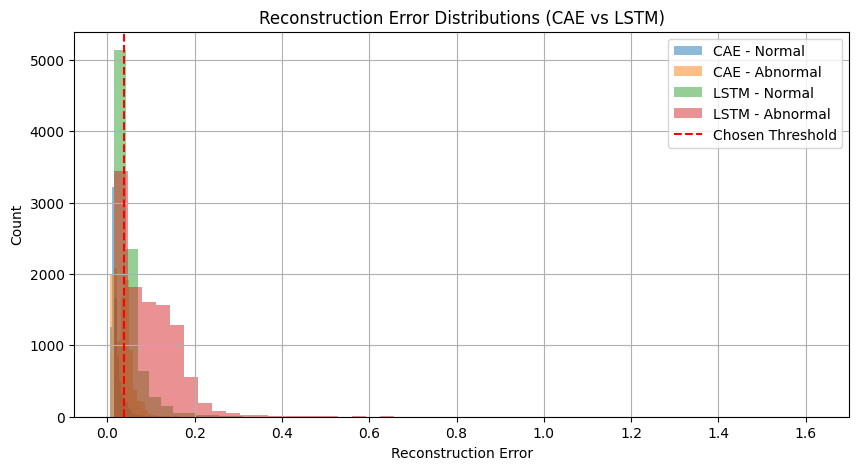

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(recon_errors[y_val_final == 0], bins=50, alpha=0.5, label='CAE - Normal')
plt.hist(recon_errors[y_val_final == 1], bins=50, alpha=0.5, label='CAE - Abnormal')
plt.hist(recon_errors_lstm[y_val_final == 0], bins=50, alpha=0.5, label='LSTM - Normal', linestyle='dashed')
plt.hist(recon_errors_lstm[y_val_final == 1], bins=50, alpha=0.5, label='LSTM - Abnormal', linestyle='dashed')
plt.axvline(chosen_thresh, color='red', linestyle='--', label='Chosen Threshold')
plt.legend()
plt.title('Reconstruction Error Distributions (CAE vs LSTM)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.grid(True)
plt.show()

To leverage the strengths of both the Convolutional Autoencoder (CAE) and the LSTM Autoencoder, we averaged their reconstruction errors to form a simple **ensemble score** and then used the **ROC** curve to find the optimal threshold that maximizes the true positive rate while minimizing the false positive rate.

In [ ]:
combined_errors = (recon_errors + recon_errors_lstm) / 2

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val_final, combined_errors)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh_combined = thresholds[optimal_idx]
print(f"Optimal ROC Threshold (Combined): {optimal_thresh_combined:.4f}")

# Predict
y_pred_combined = (combined_errors > optimal_thresh_combined).astype(int)


Optimal ROC Threshold (Combined): 0.0504


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print(confusion_matrix(y_val_final, y_pred_combined))
print(classification_report(y_val_final, y_pred_combined, digits=4))
print(f"F2-Score (Combined): {fbeta_score(y_val_final, y_pred_combined, beta=2):.4f}")


[[7521 1202]
 [4707 6008]]
              precision    recall  f1-score   support

         0.0     0.6151    0.8622    0.7180      8723
         1.0     0.8333    0.5607    0.6703     10715

    accuracy                         0.6960     19438
   macro avg     0.7242    0.7115    0.6942     19438
weighted avg     0.7354    0.6960    0.6917     19438

F2-Score (Combined): 0.6000


**LSTM-AE Performance Interpretation: Combined CAE + LSTM Errors (ROC-Based Thresholding)**

The ensemble approach—averaging reconstruction errors from the CAE and LSTM models and selecting the optimal threshold via the ROC curve—achieved the following results:

- **Accuracy**: 69.6%  
- **F2-Score**: 0.600  

**Normal class (0):**  
- Precision: 61.5%  
- Recall: 86.2%  

**Abnormal class (1):**  
- Precision: 83.3%  
- Recall: 56.1%  

These metrics suggest that the combined model:

- Retains strong ability to identify normal beats, with high recall for class 0.
- Improves overall precision on abnormal beats—when it predicts an anomaly, it's often correct.
- Still struggles to detect all abnormal cases, missing nearly 44% (recall of 56.1%).
- Achieves a modest increase in balanced performance compared to CAE alone, but remains limited in prioritizing recall for anomalies—reflected in the moderate F2-score.
- Overall, this ensemble offers a more balanced approach, reducing false positives while still catching many true anomalies. **Our best approach yet!**


## **CNN-AE Attempt**

### **CNN-AE Architecture**

In [ ]:
# Flatten the 3D input (samples, timesteps, 1) to 2D (samples, timesteps) for compatibility with Conv1D input
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_val_cnn = X_val_final.reshape((X_val_final.shape[0], X_val_final.shape[1]))

In [ ]:
# Build the CNN-AE

from tensorflow.keras import layers, Model

class CNN_AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(CNN_AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # For Conv1D
            layers.Conv1D(64, 3, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv1D(latent_dim, 3, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1D(64, 3, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### **CNN-AE Training**

In [ ]:
input_dim = X_train_cnn.shape[1]
latent_dim = 32

cnn_autoencoder = CNN_AutoEncoder(input_dim, latent_dim)
cnn_autoencoder.compile(optimizer='adam', loss='mae')
cnn_autoencoder.build((None, input_dim))
cnn_autoencoder.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'cnn__auto_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "cnn__auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 35, 32)         │         6,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,816 (26.62 KB)

 Trainable params: 6,624 (25.88 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
history = cnn_autoencoder.fit(
    X_train_cnn, X_train_cnn,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 2/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 3/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 4/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 5/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 6/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0060 - val_loss: 0.0073
Epoch 7/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0060 - val_loss: 0.0076
Epoch 8/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 9/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 10/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 11/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 12/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

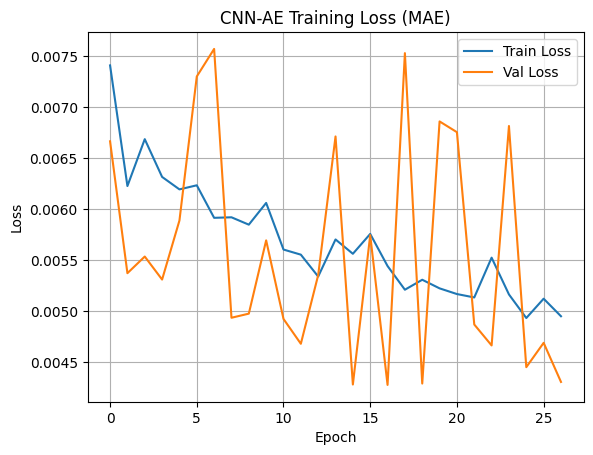

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN-AE Training Loss (MAE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Even after tuning, the training loss is fluctuating slightly but altogether decreasing.

### **Evaluating CNN-AE reconstruction error**

In [ ]:
X_val_pred_cnn = cnn_autoencoder.predict(X_val_cnn)
recon_errors_cnn = np.mean(np.abs(X_val_pred_cnn - X_val_cnn), axis=1)

608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


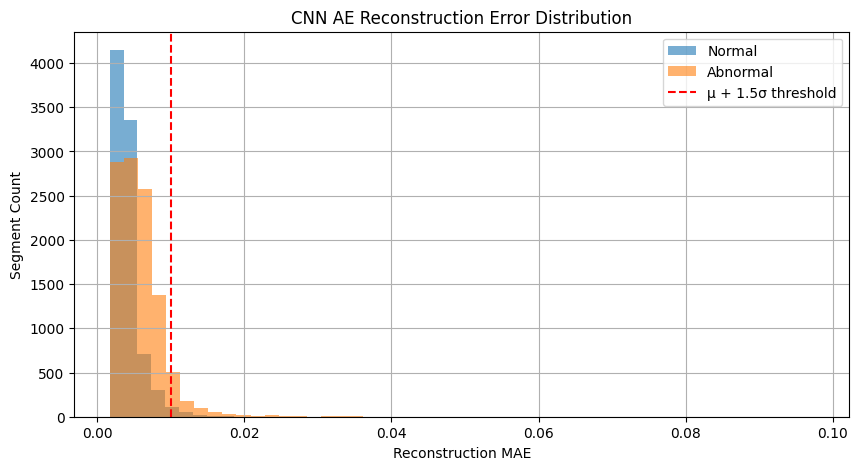

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(recon_errors_cnn[y_val_final == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(recon_errors_cnn[y_val_final == 1], bins=50, alpha=0.6, label='Abnormal')
plt.axvline(np.mean(recon_errors_cnn) + 1.5*np.std(recon_errors_cnn), color='red', linestyle='--', label='μ + 1.5σ threshold')
plt.title("CNN AE Reconstruction Error Distribution")
plt.xlabel("Reconstruction MAE")
plt.ylabel("Segment Count")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val_final, recon_errors_cnn)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_cnn = thresholds[optimal_idx]
print(f"Optimal threshold (ROC): {optimal_threshold_cnn:.4f}")


Optimal threshold (ROC): 0.0048


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

y_pred_cnn = (recon_errors_cnn > optimal_threshold_cnn).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_val_final, y_pred_cnn))
print(classification_report(y_val_final, y_pred_cnn, digits=4))
print("F2-Score:", fbeta_score(y_val_final, y_pred_cnn, beta=2))


Confusion Matrix:
[[6936 1787]
 [4743 5972]]
              precision    recall  f1-score   support

         0.0     0.5939    0.7951    0.6799      8723
         1.0     0.7697    0.5573    0.6465     10715

    accuracy                         0.6641     19438
   macro avg     0.6818    0.6762    0.6632     19438
weighted avg     0.6908    0.6641    0.6615     19438

F2-Score: 0.5898970742211422


**Performance Interpretation (CNN Autoencoder with ROC Thresholding)**

The convolutional autoencoder (CNN-AE), evaluated using an ROC-optimized threshold, produced the following results:

- **Accuracy**: 66.4%  
- **F2-Score**: 0.590  
- **Normal class (0)**:
  - Precision: 59.4%
  - Recall: 79.5%
- **Abnormal class (1)**:
  - Precision: 77.0%
  - Recall: 55.7%

These metrics indicate that the CNN-AE:

- Performs fairly well at detecting normal heartbeats, with decent recall (80%) and moderate precision.
- Has higher precision on anomalies but struggles to capture all of them, suggesting it misses a significant portion of abnormal beats.
- Achieves better balance between the two classes compared to some prior models, but still favors normal beat detection.
- The moderate F2-score shows limited effectiveness in prioritizing abnormal beat recall.


In [ ]:
# Try Huber loss instead of MAE

input_dim = X_train_cnn.shape[1]
latent_dim = 32

cnn_autoencoder = CNN_AutoEncoder(input_dim, latent_dim)
cnn_autoencoder.compile(optimizer='adam', loss='huber')
cnn_autoencoder.build((None, input_dim))
cnn_autoencoder.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'cnn__auto_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "cnn__auto_encoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 35, 32)         │         6,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,816 (26.62 KB)

 Trainable params: 6,624 (25.88 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
history = cnn_autoencoder.fit(
    X_train_cnn, X_train_cnn,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - loss: 0.0182 - val_loss: 3.5595e-04
Epoch 2/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2.7798e-04 - val_loss: 1.8208e-04
Epoch 3/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.9724e-04 - val_loss: 5.9027e-04
Epoch 4/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.8365e-04 - val_loss: 8.4338e-05
Epoch 5/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.5421e-04 - val_loss: 1.6100e-04
Epoch 6/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.2794e-04 - val_loss: 1.3289e-04
Epoch 7/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.5060e-05 - val_loss: 1.2479e-04
Epoch 8/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0234e-04 - val_loss: 1.2083e-04
Epoch 9/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.2152e-04 - val_loss: 1.0340e-04
Epoch 10/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.1059e-05 - val_loss: 1.2516e-04
Epoch 11/50
983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 7

This significantly lowered training and validation losses.

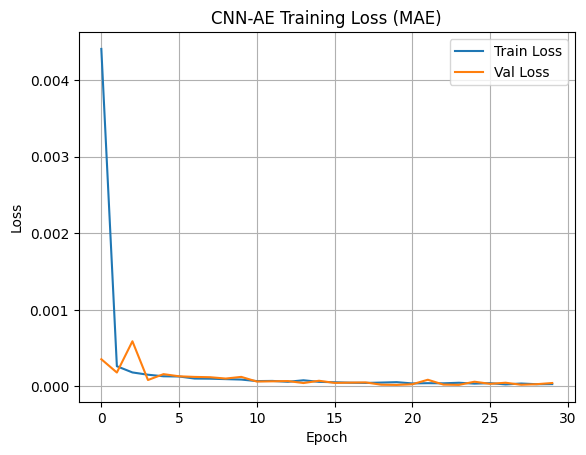

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('CNN-AE Training Loss (MAE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Try 95th percentile thresholding from normal validation reconstruction errors instead of ROC
normal_errors = recon_errors_cnn[y_val_final == 0]  # only normal segments
threshold_95 = np.percentile(normal_errors, 95)

print(f"95th percentile threshold (normal class): {threshold_95:.4f}")

95th percentile threshold (normal class): 0.0077


In [ ]:
y_pred_cnn_95 = (recon_errors_cnn > threshold_95).astype(int)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix (95th Percentile):")
print(confusion_matrix(y_val_final, y_pred_cnn_95))
print("\nClassification Report:")
print(classification_report(y_val_final, y_pred_cnn_95, digits=4))
print(f"F2-Score (95th Percentile): {fbeta_score(y_val_final, y_pred_cnn_95, beta=2):.4f}")


Confusion Matrix (95th Percentile):
[[8286  437]
 [8616 2099]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.4902    0.9499    0.6467      8723
         1.0     0.8277    0.1959    0.3168     10715

    accuracy                         0.5343     19438
   macro avg     0.6590    0.5729    0.4818     19438
weighted avg     0.6763    0.5343    0.4649     19438

F2-Score (95th Percentile): 0.2312


**Performance Interpretation (CNN Autoencoder with Huber Loss & 95th Percentile Thresholding)**

After switching to Huber loss for training and applying a 95th percentile threshold on reconstruction error, the model produced the following results:

- **Accuracy**: 53.4%  
- **F2-Score**: 0.231  
- **Normal class (0)**:
  - Precision: 49.0%
  - Recall: 95.0%
- **Abnormal class (1)**:
  - Precision: 82.8%
  - Recall: 19.6%

This configuration shows a sharp shift in behavior:

- The model is **heavily biased toward classifying inputs as normal**, as reflected by the extremely high recall for class 0 and low recall for class 1.
- **Most anomalies are missed**, despite achieving relatively high precision on the few it does detect.
- The use of the 95th percentile as a static threshold likely causes under-detection of rare anomalies, which hurts the F2-score—a metric that emphasizes recall for class 1.
- **Training loss was much lower**, indicating tighter reconstructions, but this did not translate into better anomaly detection.

Overall, this method trades off anomaly sensitivity for precision and normal class confidence, which may be undesirable in high-stakes anomaly detection contexts.


## **VAE Attempt**

### **Adjusted Preprocessing Pipeline**

We decided to rerun our data preprocessing pipeline with an **increased window size of 2160 samples (6 seconds)** to capture multi-beat ECG context, allowing the model to learn broader temporal patterns and detect more complex or subtle arrhythmias that span multiple heartbeats.

Found 48 ECG records
Processing 100 (1/48)
Saved 2256 clean segments from 100
Processing 101 (2/48)
Saved 1844 clean segments from 101
Processing 102 (3/48)
Saved 2179 clean segments from 102
Processing 103 (4/48)
Saved 2067 clean segments from 103
Processing 104 (5/48)
Saved 2222 clean segments from 104
Processing 105 (6/48)
Saved 2422 clean segments from 105
Processing 106 (7/48)
Saved 2017 clean segments from 106
Processing 107 (8/48)
Saved 2123 clean segments from 107
Processing 118 (9/48)
Saved 2271 clean segments from 118
Processing 119 (10/48)
Saved 1981 clean segments from 119
Processing 200 (11/48)
Saved 2591 clean segments from 200
Processing 201 (12/48)
Saved 1912 clean segments from 201
Processing 202 (13/48)
Saved 2125 clean segments from 202
Processing 203 (14/48)
Saved 2898 clean segments from 203
Processing 205 (15/48)
Saved 2585 clean segments from 205
Processing 207 (16/48)
Saved 2020 clean segments from 207
Processing 208 (17/48)
Saved 2911 clean segments from 208
Pr

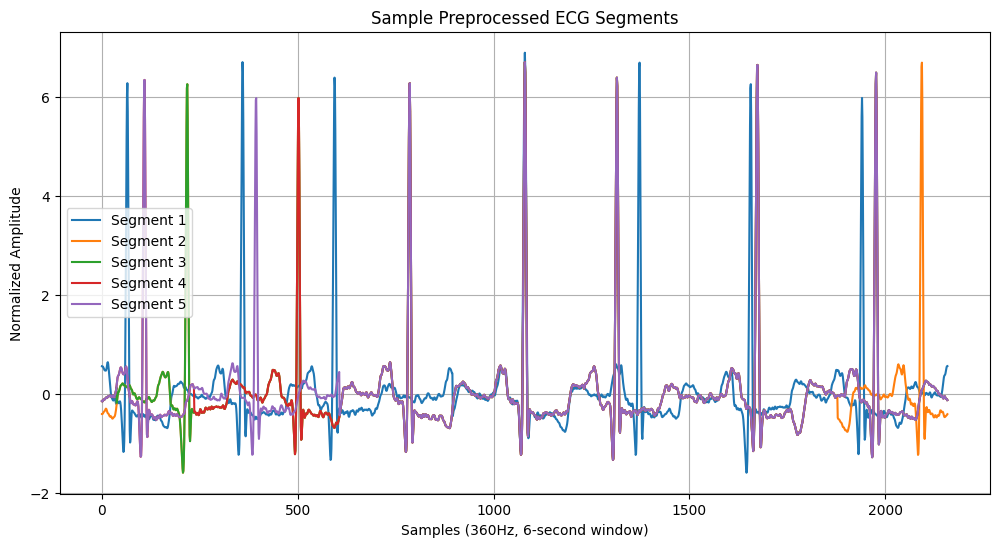

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt
from ecgdetectors import Detectors
import wfdb
import os

# Configuration
output_path = "/content/preprocessed_data/"
sampling_rate = 360  # MIT-BIH's native sampling rate
window_size = 2160  # 2160 samples @ 360Hz ≈ 6-second window

# Create output directory
os.makedirs(output_path, exist_ok=True)

# Data labeling (Normal vs abnormal)
def get_labels(record_name, r_peaks):
    annotation = wfdb.rdann(os.path.join(dataset_path, record_name), 'atr')
    symbol_map = {'N': 0, 'L': 0, 'R': 0,  # normal
                  'A': 1, 'V': 1, 'F': 1, '!': 1, 'E': 1,  # abnormal
                  '/': 1, 'f': 1, 'j': 1, 'a': 1, 'e': 1, 'J': 1}

    labels = []
    ann_idx = 0
    for peak in r_peaks:
        while ann_idx + 1 < len(annotation.sample) and annotation.sample[ann_idx] < peak:
            ann_idx += 1
        symbol = annotation.symbol[ann_idx] if ann_idx < len(annotation.symbol) else 'N'
        label = symbol_map.get(symbol, 1)  # Default to abnormal
        labels.append(label)

    return np.array(labels)

# Data Loading and Validation
def load_ecg_records(dataset_path):
    """Load MIT-BIH records with validation"""
    records = [f for f in os.listdir(dataset_path) if f.endswith('.dat')]
    print(f"Found {len(records)} ECG records")

    # Validate essential files
    for rec in records:
        base = rec[:-4]
        if not os.path.exists(os.path.join(dataset_path, base + '.hea')):
            raise FileNotFoundError(f"Missing header file for {base}")

    return [f[:-4] for f in records]  # Return list of base filenames

# Advanced Filtering Pipeline
def apply_filters(ecg_signal, fs=360):
    """Multi-stage filtering pipeline combining:
    - Butterworth bandpass (0.5-45Hz)
    - Notch filter (50/60Hz removal)
    - Wavelet denoising
    """
    # Bandpass filter
    nyq = 0.5 * fs
    low = 0.5 / nyq
    high = 45 / nyq
    b, a = butter(2, [low, high], btype='band')
    filtered = filtfilt(b, a, ecg_signal)

    # Notch filter (50Hz)
    notch_freq = 50.0
    quality = 30.0
    b, a = signal.iirnotch(notch_freq, quality, fs)
    filtered = filtfilt(b, a, filtered)

    return filtered

# Enhanced R-Peak Detection
def detect_r_peaks(ecg_signal, fs=360):
    """Robust R-peak detection with error handling"""
    detectors = Detectors(fs)
    try:
        # Try Pan-Tompkins first
        r_peaks = detectors.pan_tompkins_detector(ecg_signal)
        if len(r_peaks) < 5:  # Fallback if too few detected
            r_peaks = detectors.hamilton_detector(ecg_signal)
    except Exception as e:
        print(f"Error in detection: {e}, using Hamilton method")
        r_peaks = detectors.hamilton_detector(ecg_signal)

    return np.array(r_peaks)

# Verify success of R-Peak detection
def verify_rpeak_detection(filtered_ecg, r_peaks):
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_ecg[:1000], label='Filtered ECG')
    plt.scatter(r_peaks[r_peaks < 1000], filtered_ecg[r_peaks[r_peaks < 1000]],
                color='red', label='Detected R-Peaks')
    plt.title('R-Peak Detection Verification')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Context-Aware Segmentation
def segment_beats(ecg_signal, r_peaks, window_size):
    """Create centered segments around R-peaks with boundary checks"""
    segments = []
    valid_r_peaks = []

    for peak in r_peaks:
        start = peak - window_size // 2
        end = peak + window_size // 2

        if start >= 0 and end < len(ecg_signal):
            segment = ecg_signal[start:end]
            segments.append(segment)
            valid_r_peaks.append(peak)

    return np.array(segments), np.array(valid_r_peaks)

# Ensure R-Peaks are centered
def align_segments(segments):
    """Ensure all R-peaks are centered at position window_size//2 (i.e., 1080)"""
    aligned_segments = []
    center_position = segments[0].shape[0] // 2

    for segment in segments:
        # Find the highest peak in the segment
        peak_pos = np.argmax(segment)
        shift = center_position - peak_pos
        aligned_segment = np.roll(segment, shift)
        aligned_segments.append(aligned_segment)

    return np.array(aligned_segments)

# Patient-Specific Normalization
def zscore_normalize(segments, patient_id):
    """Patient-specific normalization with outlier protection"""
    mean = np.nanmean(segments)
    std = np.nanstd(segments)

    if std < 1e-6:
        std = 1.0

    return (segments - mean) / std

# Artifact Rejection
def reject_artifacts(segments, threshold=20):
    """Reject segments with amplitude outliers"""
    amplitudes = np.ptp(segments, axis=1)
    median_amp = np.median(amplitudes)
    mad = np.median(np.abs(amplitudes - median_amp))
    lower = median_amp - threshold * mad
    upper = median_amp + threshold * mad

    valid_mask = (amplitudes > lower) & (amplitudes < upper)
    return segments[valid_mask]

# Main Processing Pipeline
def process_record(record_name):
    """Full processing pipeline for a single record"""
    record_path = os.path.join(dataset_path, record_name)
    signal, fields = wfdb.rdsamp(record_path)
    ecg_signal = signal[:, 0]  # Use MLII lead

    filtered_ecg = apply_filters(ecg_signal)
    r_peaks = detect_r_peaks(filtered_ecg)
    segments, valid_peaks = segment_beats(filtered_ecg, r_peaks, window_size)

    labels = get_labels(record_name, valid_peaks)

    aligned_segments = align_segments(segments)
    patient_id = record_name.split('/')[-1].split('_')[0]
    normalized = zscore_normalize(aligned_segments, patient_id)
    cleaned_segments = reject_artifacts(normalized)

    # We reject artifacts, so we also need to filter labels
    cleaned_labels = labels[:len(cleaned_segments)]

    return cleaned_segments, cleaned_labels

# Process all records
all_segments = []
all_labels = []

records = load_ecg_records(dataset_path)
for i, record in enumerate(records):
    print(f"Processing {record} ({i+1}/{len(records)})")
    try:
        segments, labels = process_record(record)
        all_segments.extend(segments)
        all_labels.extend(labels)
        print(f"Saved {len(segments)} clean segments from {record}")
    except Exception as e:
        print(f"Failed to process {record}: {e}")

final_data = np.array(all_segments)
final_labels = np.array(all_labels)

np.save(os.path.join(output_path, "processed_ecg.npy"), final_data)
np.save(os.path.join(output_path, "ecg_labels.npy"), final_labels)

print(f"Final dataset shape: {final_data.shape}, Labels shape: {final_labels.shape}")
print(f"Normal: {np.sum(final_labels == 0)}, Abnormal: {np.sum(final_labels == 1)}")

# Visualization
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(final_data[i], label=f'Segment {i+1}')
plt.title('Sample Preprocessed ECG Segments')
plt.xlabel('Samples (360Hz, 6-second window)')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(True)
plt.show()

**Retrain the data**

In [2]:
# (Re-)oad the preprocessed data

import numpy as np
from sklearn.model_selection import train_test_split

# Load preprocessed segments and labels
X = np.load('/content/preprocessed_data/processed_ecg.npy')
y = np.load('/content/preprocessed_data/ecg_labels.npy')

# Sanity check
print("Data shape:", X.shape)
print("Labels distribution:", np.unique(y, return_counts=True))

# Data split for normal

X_normal = X[y == 0]
y_normal = y[y == 0]

# Split into train and val (80/20 for normal data)
X_train, X_val_normal = train_test_split(X_normal, test_size=0.2, random_state=42)

# Data split for abnormal

X_abnormal = X[y == 1]
y_abnormal = y[y == 1]

# Combine validation normal + abnormal for validation set
X_val = np.concatenate([X_val_normal, X_abnormal])
y_val = np.concatenate([np.zeros(len(X_val_normal)), np.ones(len(X_abnormal))])

# Split val set for test split (50/50 val/test)
X_val_final, X_test, y_val_final, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Confirm data split for train/val/test
print("X_train:", X_train.shape)
print("X_val:", X_val_final.shape)
print("X_test:", X_test.shape)

Data shape: (108592, 2160)
Labels distribution: (array([0, 1]), array([87147, 21445]))
X_train: (69717, 2160)
X_val: (19437, 2160)
X_test: (19438, 2160)


### **VAE Architecture**

In [ ]:
# Build the VAE

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import Model
import numpy as np

# Reshape
if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
if X_val_final.ndim == 2:
    X_val_final = X_val_final[..., np.newaxis]

input_shape = X_train.shape[1:]  # (2160, 1)
latent_dim = 16  # for low capacity but can be increased at the cost of RAM

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
inputs = layers.Input(shape=input_shape)
x = layers.Conv1D(32, 5, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense((input_shape[0] // 4) * 16, activation='relu')(latent_inputs)
x = layers.Reshape((input_shape[0] // 4, 16))(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
outputs = layers.Conv1D(1, 1, activation='linear', padding='same')(x)

decoder = Model(latent_inputs, outputs, name="decoder")
decoder.summary()

# Full VAE
class VAE(Model):
    def __init__(self, encoder, decoder, beta=1.0):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.abs(data - reconstruction))  # MAE
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        recon_loss = tf.reduce_mean(tf.abs(data - reconstruction))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = recon_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2160, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2160, 32)  │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1080, 32)  │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1080, 16)  │      1,552 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 540, 16)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8640)      │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    553,024 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 556,848 (2.12 MB)

 Trainable params: 556,848 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8640)           │       146,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 540, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 1080, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1080, 16)       │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 2160, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2160, 32)       │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2160, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,289 (587.07 KB)

 Trainable params: 150,289 (587.07 KB)

 Non-trainable params: 0 (0.00 B)

### **VAE Training**

In [ ]:
vae = VAE(encoder, decoder, beta=10.0)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X_train, epochs=25, batch_size=8, validation_data=(X_val_final, X_val_final))


Epoch 1/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - kl_loss: 3.4930e-08 - loss: 0.5103 - recon_loss: 0.5103 - val_kl_loss: 5.5879e-08 - val_loss: 0.5592 - val_recon_loss: 0.5592
Epoch 2/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 61s 7ms/step - kl_loss: 3.5546e-08 - loss: 0.5096 - recon_loss: 0.5096 - val_kl_loss: 3.7253e-08 - val_loss: 0.5592 - val_recon_loss: 0.5592
Epoch 3/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - kl_loss: 3.2922e-08 - loss: 0.5087 - recon_loss: 0.5087 - val_kl_loss: 1.3039e-08 - val_loss: 0.5592 - val_recon_loss: 0.5592
Epoch 4/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - kl_loss: 3.3332e-08 - loss: 0.5098 - recon_loss: 0.5098 - val_kl_loss: 2.4214e-08 - val_loss: 0.5596 - val_recon_loss: 0.5596
Epoch 5/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - kl_loss: 3.1268e-08 - loss: 0.5099 - recon_loss: 0.5099 - val_kl_loss: 2.9802e-08 - val_loss: 0.5593 - val_recon_loss: 0.5593
Epoch 6/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - kl_loss: 3.2358e-08 - loss: 

### **Evaluating VAE reconstruction error**

In [ ]:
X_val_pred = vae.predict(X_val_final, batch_size=32)

608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


In [ ]:
recon_errors_vae = np.mean(np.abs(X_val_pred - X_val_final), axis=(1, 2))

#### **95th Percentile Thresholding**

In [ ]:
normal_errors = recon_errors_vae[y_val_final == 0]
threshold_95 = np.percentile(normal_errors, 95)

y_pred = (recon_errors_vae > threshold_95).astype(int)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix:")
print(confusion_matrix(y_val_final, y_pred))

print("\nClassification Report:")
print(classification_report(y_val_final, y_pred, digits=4))

print("F2-Score:", fbeta_score(y_val_final, y_pred, beta=2))

Confusion Matrix:
[[8271  436]
 [9245 1485]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.4722    0.9499    0.6308      8707
         1.0     0.7730    0.1384    0.2348     10730

    accuracy                         0.5019     19437
   macro avg     0.6226    0.5442    0.4328     19437
weighted avg     0.6383    0.5019    0.4122     19437

F2-Score: 0.16558506723757277


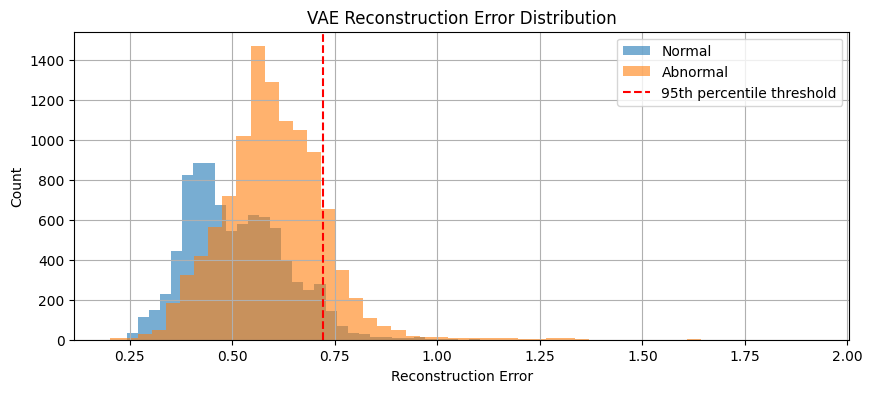

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(recon_errors_vae[y_val_final == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(recon_errors_vae[y_val_final == 1], bins=50, alpha=0.6, label='Abnormal')
plt.axvline(threshold_95, color='red', linestyle='--', label='95th percentile threshold')
plt.title('VAE Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


**Performance Interpretation (VAE with 95th Percentile Thresholding)**

The variational autoencoder (VAE) using a 95th percentile threshold yielded:

- **Accuracy**: 50.2%  
- **F2-Score**: 0.166  
- **Normal class (0)**:  
  - Precision: 47.2%  
  - Recall: 94.99%  
- **Abnormal class (1)**:  
  - Precision: 77.3%  
  - Recall: 13.84%

These results suggest that the VAE model with this thresholding is heavily biased toward predicting normal beats, resulting in very **high recall for normal (0)** but **very poor recall for abnormal (1)**. Although precision for abnormal events is relatively high (likely due to the few positive predictions being mostly correct), the **low recall drags down the F2-score**, which prioritizes detecting anomalies. The fixed high-thresholding seems to make the model struggle to generalize to unseen anomalies.


#### **ROC Thresholding**

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val_final, recon_errors_vae)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]

y_pred = (recon_errors_vae > optimal_thresh).astype(int)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix:")
print(confusion_matrix(y_val_final, y_pred))

print("\nClassification Report:")
print(classification_report(y_val_final, y_pred, digits=4))

print("F2-Score:", fbeta_score(y_val_final, y_pred, beta=2))

Confusion Matrix:
[[4903 3804]
 [2510 8220]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.6614    0.5631    0.6083      8707
         1.0     0.6836    0.7661    0.7225     10730

    accuracy                         0.6752     19437
   macro avg     0.6725    0.6646    0.6654     19437
weighted avg     0.6737    0.6752    0.6714     19437

F2-Score: 0.7480343622597554


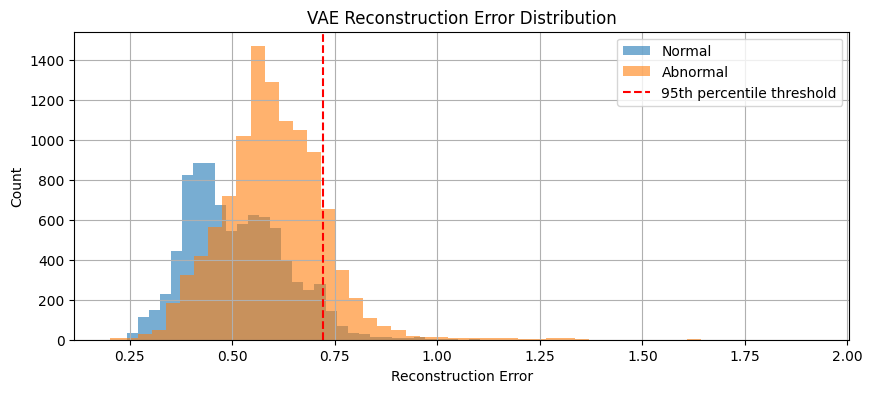

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(recon_errors_vae[y_val_final == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(recon_errors_vae[y_val_final == 1], bins=50, alpha=0.6, label='Abnormal')
plt.axvline(threshold_95, color='red', linestyle='--', label='95th percentile threshold')
plt.title('VAE Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


**Performance Interpretation (VAE with ROC-Based Thresholding)**

Using ROC analysis to find an optimal threshold significantly improved the VAE’s performance:

- **Accuracy**: 67.5%  
- **F2-Score**: 0.748  
- **Normal class (0)**:  
  - Precision: 66.1%  
  - Recall: 56.3%  
- **Abnormal class (1)**:  
  - Precision: 68.4%  
  - Recall: 76.6%

Compared to 95th percentile thresholding, this ROC-based approach achieves **far better balance** between detecting normal and abnormal beats. While it sacrifices some recall for the normal class, it substantially improves **recall and F2-score for anomalies**, which is typically the key goal in anomaly detection. This shows that dynamic, data-driven thresholding like ROC optimization is more effective than fixed statistical cutoffs in unsupervised settings.


#### **Optimal F2-Score Thresholding**

In [ ]:
from sklearn.metrics import precision_score, fbeta_score

best_f2 = 0
best_thresh = None

for thresh in np.linspace(min(recon_errors_vae), max(recon_errors_vae), 200):
    preds = (recon_errors_vae > thresh).astype(int)
    precision = precision_score(y_val_final, preds)
    f2 = fbeta_score(y_val_final, preds, beta=2)

    if precision >= 0.3 and f2 > best_f2:
        best_f2 = f2
        best_thresh = thresh

print("Best threshold (precision ≥ 0.3):", best_thresh)
print("Best F2-score:", best_f2)

y_pred_vae = (recon_errors_vae > best_thresh).astype(int)


Best threshold (precision ≥ 0.3): 0.20112289450982063
Best F2-score: 0.8603021361216242


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix:")
print(confusion_matrix(y_val_final, y_pred_vae))

print("\nClassification Report:")
print(classification_report(y_val_final, y_pred_vae, digits=4))

f2 = fbeta_score(y_val_final, y_pred_vae, beta=2)
print(f"F2-Score (best_thresh): {f2:.4f}")


Confusion Matrix:
[[    0  8707]
 [    1 10729]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000      8707
         1.0     0.5520    0.9999    0.7113     10730

    accuracy                         0.5520     19437
   macro avg     0.2760    0.5000    0.3557     19437
weighted avg     0.3047    0.5520    0.3927     19437

F2-Score (best_thresh): 0.8603


**Performance Interpretation (VAE with Optimal F2-Score Thresholding)**

Using threshold tuning to maximize the F2-score resulted in:

- **Accuracy**: 55.2%  
- **F2-Score**: 0.860  
- **Normal class (0)**:  
  - Precision: 0.0%  
  - Recall: 0.0%  
- **Abnormal class (1)**:  
  - Precision: 55.2%  
  - Recall: ~100%

While this approach **maximized recall for anomalies**, it did so at the cost of **completely misclassifying normal beats**. This extreme bias toward predicting all samples as abnormal highlights the **risk of over-optimizing for recall-based metrics** like F2-score without considering class balance. In practical terms, this would result in **high false alarm rates**, making it less usable despite the high F2.


#### **Isolation Forest Thresholding**

In [ ]:
from sklearn.ensemble import IsolationForest

z_mean, _, _ = encoder.predict(X_val_final)
clf = IsolationForest(contamination=0.1).fit(z_mean)
y_pred_iso = (clf.predict(z_mean) == -1).astype(int)


608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix:")
print(confusion_matrix(y_val_final, y_pred_iso))

print("\nClassification Report:")
print(classification_report(y_val_final, y_pred_iso, digits=4))

print("F2-Score:", fbeta_score(y_val_final, y_pred_iso, beta=2))

Confusion Matrix:
[[ 8707     0]
 [10730     0]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.4480    1.0000    0.6187      8707
         1.0     0.0000    0.0000    0.0000     10730

    accuracy                         0.4480     19437
   macro avg     0.2240    0.5000    0.3094     19437
weighted avg     0.2007    0.4480    0.2772     19437

F2-Score: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Performance Interpretation (Isolation Forest Thresholding)**

Applying Isolation Forest for anomaly score thresholding yielded:

- **Accuracy**: 44.8%  
- **F2-Score**: 0.0  
- **Normal class (0)**:  
  - Precision: 44.8%  
  - Recall: 100.0%  
- **Abnormal class (1)**:  
  - Precision: 0.0%  
  - Recall: 0.0%

This approach completely **failed to identify any abnormal beats**, predicting all inputs as normal. Although recall for normal beats is perfect, the classifier **lacks any discriminative power** for anomalies. This outcome suggests that the **isolation forest failed to assign meaningful anomaly scores** for thresholding in this context—likely due to high reconstruction error overlap or a lack of informative separation in the latent space.


#### **K-Means Cluster Thresholding**

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(z_mean)

normal_cluster = 0 if np.sum(clusters == 0) > np.sum(clusters == 1) else 1
y_pred = (clusters != normal_cluster).astype(int)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix:")
print(confusion_matrix(y_val_final, y_pred))

print("\nClassification Report:")
print(classification_report(y_val_final, y_pred, digits=4))

print("F2-Score:", fbeta_score(y_val_final, y_pred, beta=2))

Confusion Matrix:
[[ 8707     0]
 [10730     0]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.4480    1.0000    0.6187      8707
         1.0     0.0000    0.0000    0.0000     10730

    accuracy                         0.4480     19437
   macro avg     0.2240    0.5000    0.3094     19437
weighted avg     0.2007    0.4480    0.2772     19437

F2-Score: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Performance Interpretation (K-Means Latent Space Clustering)**

Using K-Means clustering in the latent space to classify anomalies resulted in:

- **Accuracy**: 44.8%  
- **F2-Score**: 0.0  
- **Normal class (0)**:  
  - Precision: 44.8%  
  - Recall: 100.0%  
- **Abnormal class (1)**:  
  - Precision: 0.0%  
  - Recall: 0.0%

Like the Isolation Forest approach, this method **failed to detect any abnormal beats**, classifying every input as normal. Despite achieving perfect recall for class 0, the model's inability to recognize anomalies highlights a key limitation: the **latent representations were not separable enough** for K-Means to form useful clusters. This suggests that the VAE latent space did not capture class-distinctive features well enough to support unsupervised clustering.


### **Updated VAE Models**

First, we revised our VAE architecture by:
- Reducing `beta` from 1.0 to 0.001 to **prioritize reconstruction loss over KL divergence**, which helps in retaining more anomaly-relevant detail.
- Keeping a relatively compact architecture to balance performance and memory usage.
- Maintaining MAE (mean absolute error) as the reconstruction loss for interpretability and robustness.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import Model
import numpy as np

# Reshape
if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
if X_val_final.ndim == 2:
    X_val_final = X_val_final[..., np.newaxis]

input_shape = X_train.shape[1:]  # (2160, 1)
latent_dim = 16

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
inputs = layers.Input(shape=input_shape)
x = layers.Conv1D(32, 5, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense((input_shape[0] // 4) * 16, activation='relu')(latent_inputs)
x = layers.Reshape((input_shape[0] // 4, 16))(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
outputs = layers.Conv1D(1, 1, activation='linear', padding='same')(x)

decoder = Model(latent_inputs, outputs, name="decoder")
decoder.summary()

# VAE
class VAE(Model):
    def __init__(self, encoder, decoder, beta=0.001):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.abs(data - reconstruction))  # MAE
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        recon_loss = tf.reduce_mean(tf.abs(data - reconstruction))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = recon_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 2160, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 2160, 32)  │        192 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 1080, 32)  │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 1080, 16)  │      1,552 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 540, 16)   │          0 │ conv1d_16[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 8640)      │          0 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │    553,024 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 16)        │      1,040 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 16)        │      1,040 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_3          │ (None, 16)        │          0 │ dense_13[0][0],   │
│ (Sampling)          │                   │            │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 556,848 (2.12 MB)

 Trainable params: 556,848 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8640)           │       146,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 540, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_6 (UpSampling1D)  │ (None, 1080, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 1080, 16)       │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_7 (UpSampling1D)  │ (None, 2160, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 2160, 32)       │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 2160, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,289 (587.07 KB)

 Trainable params: 150,289 (587.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X_train, epochs=25, batch_size=8, validation_data=(X_val_final, X_val_final))


Epoch 1/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step - kl_loss: 3.0293 - loss: 0.4059 - recon_loss: 0.4029 - val_kl_loss: 3.4594 - val_loss: 0.4305 - val_recon_loss: 0.4271
Epoch 2/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 75s 7ms/step - kl_loss: 3.3764 - loss: 0.3547 - recon_loss: 0.3513 - val_kl_loss: 3.3918 - val_loss: 0.4231 - val_recon_loss: 0.4197
Epoch 3/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - kl_loss: 3.4246 - loss: 0.3433 - recon_loss: 0.3399 - val_kl_loss: 3.6664 - val_loss: 0.4180 - val_recon_loss: 0.4143
Epoch 4/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 86s 7ms/step - kl_loss: 3.4775 - loss: 0.3373 - recon_loss: 0.3338 - val_kl_loss: 3.4567 - val_loss: 0.4151 - val_recon_loss: 0.4116
Epoch 5/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - kl_loss: 3.5112 - loss: 0.3319 - recon_loss: 0.3284 - val_kl_loss: 3.4058 - val_loss: 0.4125 - val_recon_loss: 0.4091
Epoch 6/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 65s 7ms/step - kl_loss: 3.5336 - loss: 0.3295 - recon_loss: 0.3260 - val_kl_loss: 3

In [ ]:
X_val_pred = vae.predict(X_val_final, batch_size=32)

608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [ ]:
recon_errors_vae = np.mean(np.abs(X_val_pred - X_val_final), axis=(1, 2))

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val_final, recon_errors_vae)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]

y_pred = (recon_errors_vae > optimal_thresh).astype(int)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix:")
print(confusion_matrix(y_val_final, y_pred))

print("\nClassification Report:")
print(classification_report(y_val_final, y_pred, digits=4))

print("F2-Score:", fbeta_score(y_val_final, y_pred, beta=2))

Confusion Matrix:
[[6716 1991]
 [2499 8231]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.7288    0.7713    0.7495      8707
         1.0     0.8052    0.7671    0.7857     10730

    accuracy                         0.7690     19437
   macro avg     0.7670    0.7692    0.7676     19437
weighted avg     0.7710    0.7690    0.7695     19437

F2-Score: 0.7744345338903316


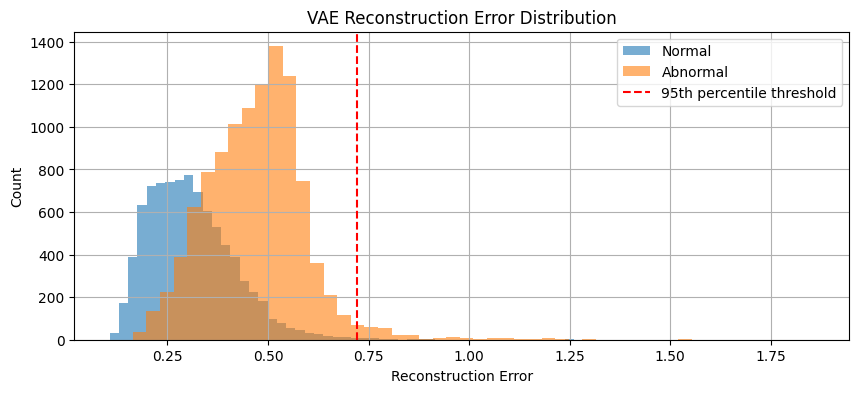

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(recon_errors_vae[y_val_final == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(recon_errors_vae[y_val_final == 1], bins=50, alpha=0.6, label='Abnormal')
plt.axvline(threshold_95, color='red', linestyle='--', label='95th percentile threshold')
plt.title('VAE Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()


This configuration yielded our **best results so far**:

- **Accuracy**: 76.9%  
- **F2-Score**: 0.774  
- **Normal class (0)**:
  - Precision: 72.9%
  - Recall: 77.1%
- **Abnormal class (1)**:
  - Precision: 80.5%
  - Recall: 76.7%

This marks a significant improvement over earlier CAE and LSTM models. The model shows **balanced performance across both classes**, with strong precision and recall for detecting anomalies. The high F2-score confirms that this setup **prioritizes recall of abnormal beats while preserving reasonable precision**, making it well-suited for ECG anomaly detection.



**Let's test it on our test data**

In [15]:
# Ensure X_test has the same shape
if X_test.ndim == 2:
    X_test = X_test[..., np.newaxis]

# Predict
X_test_pred = vae.predict(X_test, batch_size=64)

# Reconstruction error
recon_errors_test = np.mean(np.abs(X_test_pred - X_test), axis=(1, 2))

# Predict labels using the same threshold
y_test_pred = (recon_errors_test > optimal_thresh).astype(int)

# If you have ground truth labels:
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=4))
print("F2-Score:", fbeta_score(y_test, y_test_pred, beta=2))

304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[6607 2116]
 [2403 8312]]
              precision    recall  f1-score   support

         0.0     0.7333    0.7574    0.7452      8723
         1.0     0.7971    0.7757    0.7863     10715

    accuracy                         0.7675     19438
   macro avg     0.7652    0.7666    0.7657     19438
weighted avg     0.7685    0.7675    0.7678     19438

F2-Score: 0.7799129259870891


**Try DBSCAN Clustering for Threshold**

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Get latent vectors
z_mean_val, _, _ = encoder.predict(X_val_final)

# Normalize for clustering
z_scaled = StandardScaler().fit_transform(z_mean_val)

# Run DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(z_scaled)
db_labels = dbscan.labels_

# Flag outliers as anomalies
y_dbscan_pred = (db_labels == -1).astype(int)

# Evaluate
print(confusion_matrix(y_val_final, y_dbscan_pred))
print(classification_report(y_val_final, y_dbscan_pred, digits=4))


608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[    6  8701]
 [   24 10706]]
              precision    recall  f1-score   support

         0.0     0.2000    0.0007    0.0014      8707
         1.0     0.5517    0.9978    0.7105     10730

    accuracy                         0.5511     19437
   macro avg     0.3758    0.4992    0.3559     19437
weighted avg     0.3941    0.5511    0.3928     19437



ROC Clustering proved to work better in our case.

We then experimented with a larger **latent dimension of 512** and changed the reconstruction loss from **MAE to MSE** in our VAE to give the model more capacity to encode information and penalize larger errors more strongly.

In [62]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import Model
import numpy as np

# Reshape
if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
if X_val_final.ndim == 2:
    X_val_final = X_val_final[..., np.newaxis]

input_shape = X_train.shape[1:]  # (2160, 1)
latent_dim = 512 # increased greatly

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Residual Block
def residual_block(x, filters, kernel_size, stride=1):
    shortcut = x
    if x.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, padding='same', strides=stride)(shortcut)

    x = layers.Conv1D(filters, kernel_size, padding='same', strides=stride)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('gelu')(x)

    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.LayerNormalization()(x)

    x = layers.Add()([shortcut, x])
    return layers.Activation('gelu')(x)


# Encoder
inputs = layers.Input(shape=input_shape)
x = layers.Conv1D(64, 7, strides=1, padding='same')(inputs)
x = layers.LayerNormalization()(x)
x = layers.Activation('gelu')(x)

x = layers.MaxPooling1D(2)(x)
x = residual_block(x, 64, 5)
x = layers.MaxPooling1D(2)(x)
x = residual_block(x, 32, 3)
x = layers.MaxPooling1D(2)(x)
x = residual_block(x, 16, 3)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='gelu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense((input_shape[0] // 8) * 32, activation='gelu')(latent_inputs)
x = layers.Reshape((input_shape[0] // 8, 32))(x)

x = layers.Conv1DTranspose(32, 3, strides=2, padding='same', activation='gelu')(x)
x = layers.Conv1DTranspose(16, 5, strides=2, padding='same', activation='gelu')(x)
x = layers.Conv1DTranspose(8, 7, strides=2, padding='same', activation='gelu')(x)
outputs = layers.Conv1D(1, 1, activation='linear', padding='same')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# VAE
class VAE(Model):
    def __init__(self, encoder, decoder, beta=0.001):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))  # MSE
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        recon_loss = tf.reduce_mean(tf.abs(data - reconstruction))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = recon_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_47      │ (None, 2160, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_157 (Conv1D) │ (None, 2160, 64)  │        512 │ input_layer_47[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2160, 64)  │        128 │ conv1d_157[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 2160, 64)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_60    │ (None, 1080, 64)  │          0 │ activation_27[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_158 (Conv1D) │ (None, 1080, 64)  │     20,544 │ max_pooling1d_60… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1080, 64)  │        128 │ conv1d_158[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 1080, 64)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_159 (Conv1D) │ (None, 1080, 64)  │     20,544 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1080, 64)  │        128 │ conv1d_159[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 1080, 64)  │          0 │ max_pooling1d_60… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 1080, 64)  │          0 │ add_11[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_61    │ (None, 540, 64)   │          0 │ activation_29[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_161 (Conv1D) │ (None, 540, 32)   │      6,176 │ max_pooling1d_61… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 540, 32)   │         64 │ conv1d_161[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 540, 32)   │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_162 (Conv1D) │ (None, 540, 32)   │      3,104 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_160 (Conv1D) │ (None, 540, 32)   │      2,080 │ max_pooling1d_61… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 540, 32)   │         64 │ conv1d_162[0][0]

 Total params: 1,425,744 (5.44 MB)

 Trainable params: 1,425,744 (5.44 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_48 (InputLayer)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 8640)           │     4,432,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_23 (Reshape)            │ (None, 270, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_12             │ (None, 540, 32)        │         3,104 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_13             │ (None, 1080, 16)       │         2,576 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_14             │ (None, 2160, 8)        │           904 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_166 (Conv1D)             │ (None, 2160, 1)        │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,438,913 (16.93 MB)

 Trainable params: 4,438,913 (16.93 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizer)
vae.fit(X_train, epochs=50, batch_size=64, validation_data=(X_val_final, X_val_final))

Epoch 1/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - kl_loss: 3.0036 - loss: 0.3244 - recon_loss: 0.3214 - val_kl_loss: 3.3604 - val_loss: 0.1529 - val_recon_loss: 0.1495
Epoch 2/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - kl_loss: 3.1324 - loss: 0.0410 - recon_loss: 0.0379 - val_kl_loss: 3.2861 - val_loss: 0.1372 - val_recon_loss: 0.1339
Epoch 3/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - kl_loss: 3.1378 - loss: 0.0322 - recon_loss: 0.0291 - val_kl_loss: 3.1919 - val_loss: 0.1261 - val_recon_loss: 0.1230
Epoch 4/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - kl_loss: 3.1220 - loss: 0.0280 - recon_loss: 0.0249 - val_kl_loss: 3.2367 - val_loss: 0.1220 - val_recon_loss: 0.1187
Epoch 5/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - kl_loss: 3.1134 - loss: 0.0261 - recon_loss: 0.0230 - val_kl_loss: 3.1727 - val_loss: 0.1172 - val_recon_loss: 0.1141
Epoch 6/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - kl_loss: 3.0967 - loss: 0.0240 - recon_loss: 0.0209 - val_kl_loss: 3.221

In [69]:
X_val_pred = vae.predict(X_val_final, batch_size=64)

recon_errors_vae = np.mean(np.abs(X_val_pred - X_val_final), axis=(1, 2))

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val_final, recon_errors_vae)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]

y_pred = (recon_errors_vae > optimal_thresh).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix:")
print(confusion_matrix(y_val_final, y_pred))

print("\nClassification Report:")
print(classification_report(y_val_final, y_pred, digits=4))

print("F2-Score:", fbeta_score(y_val_final, y_pred, beta=2))


304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Confusion Matrix:
[[7094 1613]
 [4128 6602]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.6322    0.8147    0.7119      8707
         1.0     0.8037    0.6153    0.6970     10730

    accuracy                         0.7046     19437
   macro avg     0.7179    0.7150    0.7044     19437
weighted avg     0.7268    0.7046    0.7037     19437

F2-Score: 0.6455461034516476


While training loss decreased significantly (suggesting better reconstruction fidelity), the final evaluation yielded:

- **Accuracy**: 70.5%  
- **F2-Score**: 0.646  
- **Normal class (0)**:
  - Precision: 63.2%
  - Recall: 81.5%
- **Abnormal class (1)**:
  - Precision: 80.4%
  - Recall: 61.5%

Compared to earlier models like CAE, LSTM, and CNN-AE, this VAE configuration performs better overall. However, it **underperforms compared to our previous, simpler VAE** (with `latent_dim=16` and `beta=0.001`), which had a higher F2-score and better class balance.

This suggests that **overcapacity (latent_dim too large) may have caused overfitting or unnecessary compression**, and that **MAE might have been better aligned with our anomaly detection goals**.

To strike a balance between model capacity and generalization, we **reduced the latent dimension to 32** (a midpoint between previous values) and **returned to using MAE** as the reconstruction loss.

In [71]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import numpy as np

# Ensure shape
if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
if X_val_final.ndim == 2:
    X_val_final = X_val_final[..., np.newaxis]

input_shape = X_train.shape[1:]  # (2160, 1)
latent_dim = 32  # Up from 16, still compact

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
inputs = layers.Input(shape=input_shape)
x = layers.Conv1D(32, 5, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling1D(2)(x)

x = layers.Conv1D(16, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.MaxPooling1D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation='leaky_relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense((input_shape[0] // 4) * 16, activation='leaky_relu')(latent_inputs)
x = layers.Reshape((input_shape[0] // 4, 16))(x)

x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(16, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(32, 5, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

outputs = layers.Conv1D(1, 1, activation='linear', padding='same')(x)
decoder = Model(latent_inputs, outputs, name="decoder")

# VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder, beta=0.001):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.abs(data - reconstruction))  # MAE
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        recon_loss = tf.reduce_mean(tf.abs(data - reconstruction))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = recon_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

# Compile & train
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
vae.fit(X_train, epochs=25, batch_size=8, validation_data=(X_val_final, X_val_final))


Epoch 1/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - kl_loss: 3.3070 - loss: 0.3647 - recon_loss: 0.3614 - val_kl_loss: 3.7520 - val_loss: 0.3595 - val_recon_loss: 0.3558
Epoch 2/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - kl_loss: 3.6245 - loss: 0.3018 - recon_loss: 0.2982 - val_kl_loss: 3.3753 - val_loss: 0.3495 - val_recon_loss: 0.3461
Epoch 3/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - kl_loss: 3.6838 - loss: 0.2871 - recon_loss: 0.2834 - val_kl_loss: 3.8051 - val_loss: 0.3429 - val_recon_loss: 0.3391
Epoch 4/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - kl_loss: 3.7141 - loss: 0.2777 - recon_loss: 0.2740 - val_kl_loss: 4.0841 - val_loss: 0.3359 - val_recon_loss: 0.3318
Epoch 5/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - kl_loss: 3.7595 - loss: 0.2700 - recon_loss: 0.2662 - val_kl_loss: 3.9811 - val_loss: 0.3338 - val_recon_loss: 0.3298
Epoch 6/25
8715/8715 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - kl_loss: 3.7986 - loss: 0.2640 - recon_loss: 0.2602 - val_kl_loss: 3

In [73]:
X_val_pred = vae.predict(X_val_final, batch_size=8)

recon_errors_vae = np.mean(np.abs(X_val_pred - X_val_final), axis=(1, 2))

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val_final, recon_errors_vae)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]

y_pred = (recon_errors_vae > optimal_thresh).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix:")
print(confusion_matrix(y_val_final, y_pred))

print("\nClassification Report:")
print(classification_report(y_val_final, y_pred, digits=4))

print("F2-Score:", fbeta_score(y_val_final, y_pred, beta=2))


2430/2430 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Confusion Matrix:
[[6745 1962]
 [2588 8142]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.7227    0.7747    0.7478      8707
         1.0     0.8058    0.7588    0.7816     10730

    accuracy                         0.7659     19437
   macro avg     0.7643    0.7667    0.7647     19437
weighted avg     0.7686    0.7659    0.7665     19437

F2-Score: 0.7677655401327701


This led to strong performance:

- **Accuracy**: 76.6%  
- **F2-Score**: 0.768  
- **Normal class (0)**:
  - Precision: 72.3%
  - Recall: 77.5%
- **Abnormal class (1)**:
  - Precision: 80.6%
  - Recall: 75.9%

These results are **comparable to our best-performing model** (the simpler VAE with `latent_dim=16` and MAE), demonstrating that a moderate latent space paired with MAE yields strong anomaly detection performance while maintaining class balance.

## **Lightweight LSTM-VAE**

To combine the strengths of LSTMs and VAEs, we implemented a **lightweight LSTM-VAE** with a small latent dimension (8) and trained it for only **8 epochs** due to GPU limitations in Google Colab. The model uses MSE as the reconstruction loss and a low `β = 0.001`.

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
if X_val_final.ndim == 2:
    X_val_final = X_val_final[..., np.newaxis]

input_shape = X_train.shape[1:]  # (2160, 1)
latent_dim = 8  # Smaller latent space

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = layers.Input(shape=input_shape)
x = layers.LSTM(32, return_sequences=False)(encoder_inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.RepeatVector(input_shape[0])(latent_inputs)
x = layers.LSTM(32, return_sequences=True)(x)
decoder_outputs = layers.TimeDistributed(layers.Dense(1))(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# VAE
class VAE(Model):
    def __init__(self, encoder, decoder, beta=0.001):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = recon_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

# Compile and train
vae = VAE(encoder, decoder, beta=0.001)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
vae.fit(X_train, epochs=8, batch_size=64, validation_data=(X_val_final, X_val_final))


Epoch 1/8
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 449s 329ms/step - kl_loss: 0.2301 - loss: 0.9860 - recon_loss: 0.9857 - val_kl_loss: 0.1967 - val_loss: 1.0305 - val_recon_loss: 1.0303
Epoch 2/8
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 332s 305ms/step - kl_loss: 0.2303 - loss: 0.9680 - recon_loss: 0.9678 - val_kl_loss: 0.3785 - val_loss: 1.0291 - val_recon_loss: 1.0288
Epoch 3/8
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 335s 307ms/step - kl_loss: 0.3637 - loss: 0.9667 - recon_loss: 0.9663 - val_kl_loss: 0.4654 - val_loss: 1.0282 - val_recon_loss: 1.0277
Epoch 4/8
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 333s 305ms/step - kl_loss: 0.4496 - loss: 0.9676 - recon_loss: 0.9672 - val_kl_loss: 0.4701 - val_loss: 1.0276 - val_recon_loss: 1.0271
Epoch 5/8
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 333s 305ms/step - kl_loss: 0.4944 - loss: 0.9648 - recon_loss: 0.9643 - val_kl_loss: 0.6766 - val_loss: 1.0290 - val_recon_loss: 1.0283
Epoch 6/8
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 334s 306ms/step - kl_loss: 0.5432 - loss: 0.9668 - recon_loss: 0.9663 - va

In [6]:
X_val_pred = vae.predict(X_val_final, batch_size=8)

recon_errors_vae = np.mean(np.abs(X_val_pred - X_val_final), axis=(1, 2))

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val_final, recon_errors_vae)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]

y_pred = (recon_errors_vae > optimal_thresh).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score

print("Confusion Matrix:")
print(confusion_matrix(y_val_final, y_pred))

print("\nClassification Report:")
print(classification_report(y_val_final, y_pred, digits=4))

print("F2-Score:", fbeta_score(y_val_final, y_pred, beta=2))


2430/2430 ━━━━━━━━━━━━━━━━━━━━ 258s 98ms/step
Confusion Matrix:
[[5123 3584]
 [3032 7698]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.6282    0.5884    0.6076      8707
         1.0     0.6823    0.7174    0.6994     10730

    accuracy                         0.6596     19437
   macro avg     0.6553    0.6529    0.6535     19437
weighted avg     0.6581    0.6596    0.6583     19437

F2-Score: 0.710121397734401


Despite its simplicity and limited training time, the model performed reasonably:

- **Accuracy**: 65.9%  
- **F2-Score**: 0.710  
- **Normal class (0)**:
  - Precision: 62.8%
  - Recall: 58.8%
- **Abnormal class (1)**:
  - Precision: 68.2%
  - Recall: 71.7%

These results show that even a small LSTM-VAE captures useful temporal features, performing **competitively with earlier CAE and CNN-AE models**. With more training time and capacity, it has the potential to match or outperform our best convolutional VAEs.